<a href="https://colab.research.google.com/github/smartinot/DL_assignment/blob/master/my_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression : Predicting the cartesian coordinates of a triangle's vertices 

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Conv2D, Dense, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import glorot_normal
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib.patches as patches

In [5]:
# I used google colab notebook to speed up training so this cell is related to colab.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 1. Defining helper functions

Functions to generate grayscale images of triangles and visualize the model's predictions

In [0]:
# Helper functions

## Regression
np.random.seed(0)
def generate_dataset_regression(n_train, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([n_train,im_size])
    Y = np.zeros([n_train, 6])
    sys.stdout.write('Creating data:')
    for i in range(n_train):
        if i % 100 == 0:
            sys.stdout.write('.')
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    sys.stdout.write(' Finished | ')
    return [X, Y]



def generate_test_set_regression(n_test, noise=0):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(n_test, noise)
    return [X_test, Y_test]



def visualize_vertices(x, y_true, y_pred):
    fig=plt.figure(figsize=(10, 5))
    
    ax = fig.add_subplot(121)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y_true.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    plt.title('Groudtruth vertices')
    
    ax1 = fig.add_subplot(122)
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax1.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])

    xy = y_pred.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax1.add_patch(tri)
    plt.title('Predicted vertices')
    plt.show()
    
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]



def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    


# 2. Ordering functions

In order for the CNN model to better predict the vertices' coordinates, I thought it would be best to order somehow the vertices. The idea was to mimic the case were a CNN has to predict the coordinates of a rectangular bounding box in object detection problems.

Of course, since we are working with triangles, it can be difficult to have well-set order of the vertices for all triangles. 

The idea behing using CNNs to do a regression is that the ouptut is continuous with respect to its components. That is to say that the first coordinates should yield continuous predictions when switching from one triangle to another.

In this section I coded a number of "ordering" functions:

  - Naive order : order the vertices according to the value of their oordinates y and abscisse x in crescent order as much as possible
  - Order by the distance of each vertice to the triangle's barycentre
  - Order by the size of the angle values at each vertice
  - Clockwise order with respect to the barycentre
  - Switching to polar coordinates and order by the norm or angle
  
  
  
  
 I thought of other normalizations but no time to explore :
 - ordering the vertices in function of the length of the triangle's edges
 - ordering according to the distance of the vertices to the origin ...
 
 But I think that these would not have worked well as learning distances seems complicated for CNNs.
 
 
 
### ** Results**

Personnally, I thought that ordering by the angles would work better because, if we consider a triangle and order its vertices according to their corresponding angles, the "first vertices" would always be the same even if we rotated or translated the triangle. In that sense, that normalization seemed continuous.

I found that the **clockwise order** yields the best results.
I guess the reason why it works better than the other 'normalization' methods is that the order is somewhat continuous with respect to the barycentre. 
In contrast naive order induced a discontinuity in the output : bad normalization.


### Discussion

Regarding the results, I think that with more time, twiking the parameters and the number of parameters and playing with the regularization methods, the results could have been even better regarding the **bias/variance tradeoff**


### a. Naive Order

In [0]:
def naive_order(vertices):
    x1, y1, x2, y2, x3, y3 = vertices
    y = [y1, y2, y3]
    x = [x1, x2, x3]
  
    i = [0,1,2]

    ymax= y[y.index(np.max(y))] +1
    xymax= x[y.index(np.max(y))] +1
    i.remove(y.index(np.max(y)))

    ymin= y[y.index(np.min(y))] -1
    xymin= x[y.index(np.min(y))] -1
    i.remove(y.index(np.min(y)))

    ymid = y[i[0]]
    xymid = x[i[0]] 
    
    if ymid == ymax:
        if xymid > xymax:
            ymid, ymax = ymax, ymid
            xymid, xymax = xymax, xymid
    elif ymid == ymin:
        if xymid > xymin:
            ymid, ymin = ymin, ymid
            xymid, xymin = xymin, xymid
            
    return np.array([xymax, ymax, xymid, ymid, xymin, ymin])
  
def scale_back(Y):
    new_Y = np.zeros(Y.shape)
    for i in range(len(Y)):
        x1, y1, x2, y2, x3, y3 = Y[i,:]
        new_Y[i,:] = np.array([x1-1, y1, x2, y2, x3+1, y3])
    return new_Y

### b. Order by the modules of the points

In [0]:
def norm_order(vertices):
    x1, y1, x2, y2, x3, y3 = vertices
    y = [y1, y2, y3]
    x = [x1, x2, x3]
  
    max_i, mid_i, min_i = 0, 0, 0
    max_norm, min_norm = np.linalg.norm([x[0], y[0]]), np.linalg.norm([x[0], y[0]])
    for i in range(3):
        norm_i = np.linalg.norm([x[i], y[i]])
        if norm_i > max_norm:
            max_i = i
            max_norm = norm_i
        elif norm_i < min_norm:
            min_i = i
            min_norm = norm_i   
        else:
            mid_i = i
    return np.array([x[max_i], y[max_i], x[mid_i], y[mid_i], x[min_i], y_min[i]])

### c. Order by distance to the barycentre

In [0]:
# Order with distance to barycentre
def barycentre_order(triangle):
    x1, y1, x2, y2, x3, y3 = triangle
    x, y = [x1, x2, x3], [y1, y2, y3]
    xg, yg = np.mean(x), np.mean(y)
    d = [np.linalg.norm(np.array([xg, yg]) - np.array([x[i], y[i]])) for i in range(3)]
    
    zipped = list(enumerate(d, 0))
    zipped.sort(key = lambda t: t[1], reverse=True)
    sorted_ind, _ = zip(*zipped)
    new = []
    for i in sorted_ind:
        new.append(x[i])
        new.append(y[i])
    return np.array(new)

### d. Order by the size of the angles

In [0]:
# Angle order
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def my_angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_order(triangle):
    x1, y1, x2, y2, x3, y3 = triangle
    x, y = [x1, x2, x3], [y1, y2, y3]
    indices = [0, 1, 2]
    
    angles = []
    angles.append(my_angle_between([x2-x1, y2-y1], [x3-x1, y3-y1]))
    angles.append(my_angle_between([x1-x2, y1-y2], [x3-x2, y3-y2]))
    angles.append(my_angle_between([x2-x3, y2-y3], [x1-x3, y1-y3]))
    zipped = list(enumerate(angles, 0))
    zipped.sort(key = lambda t: t[1], reverse=True)
    sorted_ind, _ = zip(*zipped)
    
    new = []
    for i in sorted_ind:
        new.append(x[i])
        new.append(y[i])
    return np.array(new)

### e. Clockwise order with respect to the barycentre

In [0]:
# Clockwise ordering
def angle_between(v1, v2):
    v1_u = unit_vector(v1); x1, y1 = v1_u
    v2_u = unit_vector(v2); x2, y2 = v2_u
    
    dot = x1*x2 + y1*y2      # dot product
    det = x1*y2 - y1*x2      # determinant
    angle=math.atan2(det, dot)*180/np.pi
    if angle<0:
        return -angle
    elif angle>0:
        return 360-angle

def order_clockwise(triangle):
    x1, y1, x2, y2, x3, y3 = triangle
    x, y = [x1, x2, x3], [y1, y2, y3]
    xg, yg = np.mean(x), np.mean(y)
    indices = [0, 1, 2]
    
    vg = np.array([xg, yg])
    angles = []
    for i in range(len(x)):
        vi = np.array([x[i], y[i]])
        if xg==0:
            v_ref = np.array([-1,0])
        else:
            v_ref = np.array([-xg, 0])
        
        angle = angle_between(v_ref, vi-vg)
        if not angle:
          print("bad angle for : ", triangle)
        angles.append(angle)
        
    zipped = list(enumerate(angles, 0))
    zipped.sort(key = lambda t: t[1])
    sorted_ind, _ = zip(*zipped)
    new = []
    for i in sorted_ind:
        new.append(x[i])
        new.append(y[i])
    return np.array(new)

### f. Switch to polar coordinates and order naively

In [0]:
# Polar coordiantes
def polar_coord(x,y):
    r = math.sqrt(math.pow(x,2) + math.pow(y,2)) 
    t = 360 - angle_between(np.array([1,0]), np.array([x,y]))
    return r,t
  
def polar_order(triangle):
    x1,y1,x2,y2,x3,y3 = triangle
    x, y = [x1, x2, x3], [y1, y2, y3]
    coord = []
    for i in range(len(x)):
        r, t = polar_coord(x[i], y[i])
        coord.append((r, t))
    
    coord.sort(key = lambda t: t[1])
   
    r, t = zip(*coord)
    new = []
    for i in range(len(r)):
        new.append(r[i])
        new.append(t[i])
    return np.array(new)

def polar_to_cart(r, t):
    x = np.cos(t)*r
    y = np.sin(t)*r
    return x,y
    
def triangle_to_cart(triangle):
    x1,y1,x2,y2,x3,y3 = triangle
    x, y = [x1, x2, x3], [y1, y2, y3]
    
    new = []
    for i in range(len(x)):
      new_x, new_y = polar_to_cart(x[i], y[i])
      new.append(new_x)
      new.append(new_y)
    return np.array(new)

### g. Sum up function for ordering

Here I create a function that I will call at different times to preprocess the datasets with each normalization methods proposed above.

In [0]:
def order(Y, ordering='clockwise', referential=False):
    Y_order = deepcopy(Y)
    for i in range(len(Y)):
        if ordering == 'clockwise':
            Y_order[i,:] = order_clockwise(Y[i,:])
        elif ordering == 'angle':
            Y_order[i,:] = angle_order(Y[i,:])
        elif ordering == 'naive':
            Y_order[i,:] = naive_order(Y[i,:])
        elif ordering == 'barycentre':
            Y_order[i,:] = barycentre_order(Y[i,:])
        elif ordering == 'norm':
            Y_order[i,:] = norm_order(Y[i,:])
        elif ordering == "polar":
            Y_order[i,:] = polar_order(Y[i,:])
    return Y_order

# 3. Creating the train and test data


To encourage good generalization I created 20000 images. 
I then tried numerous training set sizes, from 1000 images to 18000 to see how adding mode data yields better generalization from the CNN model I chose.

Indeed adding more data gave better results, eventhough the model was slower to train.

Creating data:........................................................................................................................................................................................................ Finished | Creating data:. Finished | 

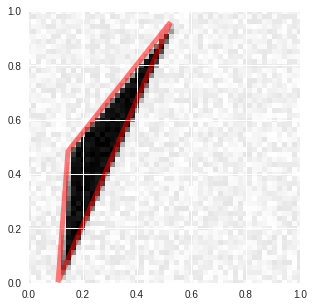

In [15]:
# Creating data
import matplotlib.pyplot as plt
import sys
n_train = 20000
n_val = 100
n_test = 100
noise=30

[X_train, Y_train] = generate_dataset_regression(n_train, noise=noise)
[X_val, Y_val] = generate_test_set_regression(n_val, noise=noise)
# [X_test, Y_test] = generate_test_set_regression(n_test, noise=noise)
[X_test, Y_test] = [X_val, Y_val]

visualize_prediction(X_train[0], Y_train[0])

_, l = X_train.shape
_, n_classes = Y_train.shape
rows = int(np.sqrt(l))
cols = int(np.sqrt(l))
channels = 1

In [0]:
# Ordering the target vertices
import math


def get_datasets(ordering='barycentre', with_center=False, referential=False):

    Y_train_order = order(Y_train, ordering=ordering, referential=referential)
    Y_val_order = order(Y_val, ordering=ordering, referential=referential)
    Y_test_order = order(Y_test, ordering=ordering, referential=referential)

    if with_center:
        Y_train_order = find_centre(Y_train_order)
        Y_val_order = find_centre(Y_val_order)
        Y_test_order = find_centre(Y_test_order)

    n_classes = Y_test_order.shape[1]; print("Number of classes : ", n_classes)

    X_train_order_cnn = np.reshape(X_train, (n_train, rows, cols,  channels))
    Y_train_order_cnn = np.reshape(Y_train_order, (n_train, n_classes))

    X_val_order_cnn = np.reshape(X_val, (n_val, rows, cols,  channels))
    Y_val_order_cnn = np.reshape(Y_val_order, (n_val, n_classes))

    X_test_order_cnn = np.reshape(X_test, (n_test, rows, cols,  channels))
    Y_test_order_cnn = np.reshape(Y_test_order, (n_test, n_classes))  
    
    
    return X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn

In [0]:
def find_centre(Y):
    n,p = Y.shape
    new_Y = np.zeros((n, p+2))
    for i in range(n):
        x1, y1, x2, y2, x3, y3 = Y[i,:]
        new_Y[i,:p] = Y[i,:]
        new_Y[i,p] = (x1 + x2 + x3)/3
        new_Y[i,p+1] = (y1 + y2 + y3)/3
    return new_Y

# 4. Creating the model


To create the CNN model, I took into account the following points : 
- **ReLU **activation functions are usually better than other activations (no vanishing gradient issue, etc...)
- No softmax at the end since we do not predict probabilities.
- The **Effective Receptive Field** : using several convolutional layers with 3 by 3 filters was more computationnaly efficient as it gave less parameters. Indeed using 2 conv layers with 3x3 filters "sees" the same amount of image that a single conv layer with 5x5 layer AND has less parameters AND includes more non-linearity through the acitvation function (ReLU), thus helping model complex data.
- Increasing the spectral dimension as the model gets deeper and the spatial dimension gets smaller with MaxPooling and deeper conv layers.
- Best to use deep architecture as the deepest conv layers capture **high level features** that are useful to enhance the network's generalization power.


When creating the model, I chose to diminish as much as possible the spatial dimension while increasing the spectral dimension and used **Dropout** regularization to reduce overfitting to a maximum.

I used **Xavier**'s initialization to initialize the weights.

Also, only in the case of clockwise noramlization (since it worked way better that the others), I used **checkpoints to save the model's parameters** whenever the validation loss hit a new low. That way I could **restore the best performing weights**.

### **Influence of the number of conv layers e.g. number of parameters** :  
I tried different models, with a different number of conv layers, as adding conv layers increased the number of parameters and thus increased the risk of witnessing **high variance e.g. overfitting**. The first model I trained had around 23,000 parameters and as I increased the size of the training set, I observed that the training loss (**MSE**) did not decrease enough to give good results : **high bias**. So I kept adding layers and training the models each time and concluded that the following model generalized better without overfitting too much, e.g. training loss and validation loss were close and decreased together.

In [0]:
from tensorflow.keras import Sequential

def my_regressor(drop_rate=0.5, regul=0.003, decay=0.005,  n_classes=6, lr=0.008, loss='MSE'): 
    
    regressor = Sequential()
    regressor.add(Conv2D(filters=8, kernel_size=3, kernel_initializer='glorot_normal', activation='relu', input_shape=(rows, cols, channels)))
    regressor.add(Dropout(rate=drop_rate, seed=42))
    regressor.add(MaxPool2D(pool_size=2, strides=2))
    regressor.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='glorot_normal', activation='relu'))
    regressor.add(MaxPool2D(pool_size=2, strides=2))
    regressor.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='glorot_normal', activation='relu'))
    regressor.add(MaxPool2D(pool_size=2, strides=2))
    regressor.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', activation='relu'))
    regressor.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', activation='relu'))
    regressor.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='glorot_normal', activation='relu'))
    regressor.add(Dropout(rate=drop_rate, seed=42))
    regressor.add(Flatten())
    regressor.add(Dense(n_classes, activation='relu'))

    regressor.compile(optimizer=Adam(lr=lr, decay=decay), loss=loss)
    return regressor

How many parameters does the model have ?

In [19]:
my_regressor().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 8)         80        
_________________________________________________________________
dropout (Dropout)            (None, 70, 70, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
__________

In [0]:
def back_to_cart(Y):
  Y_plot = np.zeros(Y.shape)
  for i in range(len(Y)):
      Y_plot[i,:] = triangle_to_cart(Y[i,:])
  return Y_plot    

# See on test set
def plot_predictions(regressor, x, y_true, ordering=None):
    y_pred = regressor.predict(x)
    
    # If we switched to polar coordinates for training, here we switch back to cartesians
    # for visualization purposes
    if ordering == 'polar':
        y_true = back_to_cart(y_true)
        y_pred = back_to_cart(y_pred)
        
    fig = plt.figure(figsize=(20,20))
    c=0
    for i in range(5):
        for j in range(5):
            ax = fig.add_subplot(5,5, c+1)
            I = x[c].reshape((IMAGE_SIZE,IMAGE_SIZE))
            ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])

            xy = y_true[c,:6].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'g', linewidth = 5, alpha = 0.5)
            ax.add_patch(tri)

            xy = y_pred[c, :6].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
            ax.add_patch(tri)
            
            if y_true.shape[1] >6:
                ax.plot(y_pred[c,6], y_pred[c, 7], 'r')
                ax.plot(y_true[c,6], y_true[c, 7], 'g')
            c+=1
    plt.show()

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# 5. Training with different normalization


In each case I used **learning rate decay** when the validation loss stopped decreasing in order to circumvent overshooting the minimum.

** Best normalization : clockwise order - train loss = 0.0029 - val loss = 0.0035**

### a. Naive Ordering : ordering coordinates in crescent order

In [29]:
X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn = get_datasets(ordering='naive', with_center=False)
n_classes = Y_train_order_cnn.shape[1]
regressor1 = my_regressor(lr=0.005, n_classes=n_classes, drop_rate=0, decay=0)

Number of classes :  6


In [30]:
n_epochs = 30
n_data = 10000

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0005, patience=7, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5, verbose=0, mode='auto', baseline=None)

history_order = regressor1.fit(X_train_order_cnn[:n_data], Y_train_order_cnn[:n_data], 
                              epochs=n_epochs,
                              batch_size=16, 
                              validation_data=[X_val_order_cnn, Y_val_order_cnn],
                              verbose=1,
                              callbacks=[reduce_lr])

Train on 10000 samples, validate on 100 samples
Epoch 1/30
10000/10000 [==============================] - 8s 759us/step - loss: 0.4579 - val_loss: 0.2184
Epoch 2/30
10000/10000 [==============================] - 7s 705us/step - loss: 0.2186 - val_loss: 0.2092
Epoch 3/30
10000/10000 [==============================] - 7s 702us/step - loss: 0.2143 - val_loss: 0.2070
Epoch 4/30
10000/10000 [==============================] - 7s 701us/step - loss: 0.2128 - val_loss: 0.2070
Epoch 5/30
10000/10000 [==============================] - 7s 709us/step - loss: 0.2117 - val_loss: 0.2056
Epoch 6/30
10000/10000 [==============================] - 7s 697us/step - loss: 0.2115 - val_loss: 0.2048
Epoch 7/30
10000/10000 [==============================] - 7s 697us/step - loss: 0.2108 - val_loss: 0.2053
Epoch 8/30
10000/10000 [==============================] - 7s 700us/step - loss: 0.2105 - val_loss: 0.2026
Epoch 9/30
10000/10000 [==============================] - 7s 700us/step - loss: 0.2103 - val_loss: 0.203

Text(0.5,1,'Learning curves')

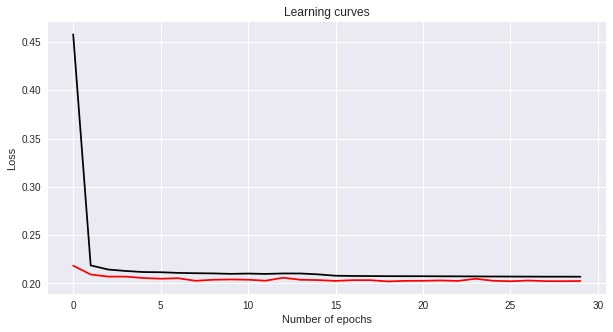

In [31]:
# Plotting learning curves

plt.figure(figsize=(10,5))
plt.plot(history_order.history['loss'], 'k', label='Training loss')
plt.plot(history_order.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Learning curves')

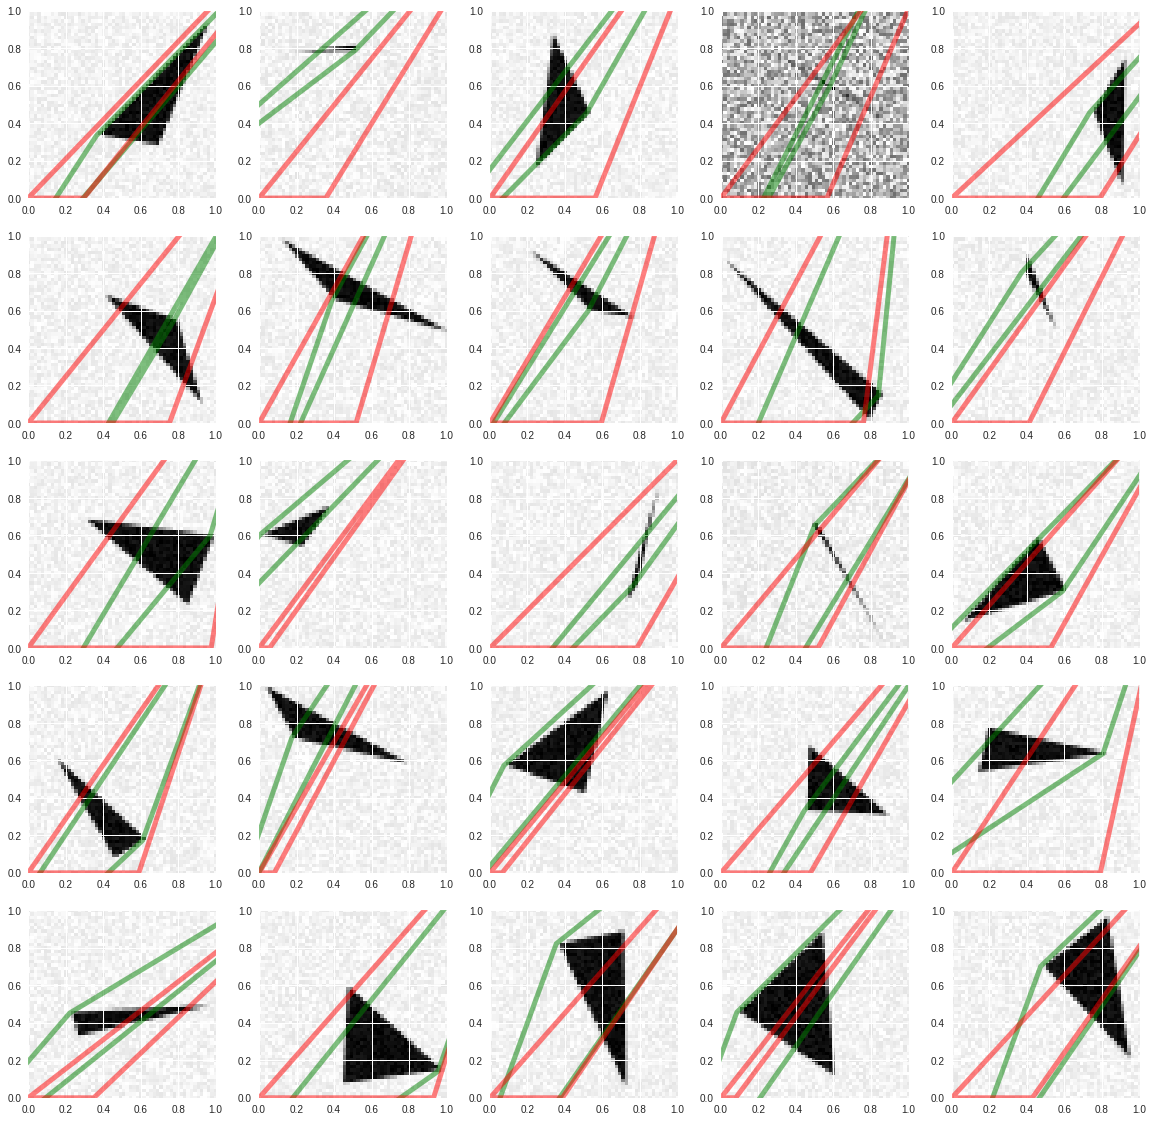

In [32]:
plot_predictions(regressor1, X_val_order_cnn[:30], Y_val_order_cnn[:30])

### b. Ordering by size of angle

Funny observation : I asked the model to **predict the coordinates of the triangle's barycentre** as well (so 8 values to predict) and it gave better results than if I didn't. 

My intuition is that indicating the center of the triangle helped the network to look at the right place.

In [43]:
X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn = get_datasets(ordering='angle', with_center=True)
n_classes = Y_train_order_cnn.shape[1]
regressor1 = my_regressor(lr=0.003, n_classes=n_classes, drop_rate=0.03, decay=0)

Number of classes :  8


In [44]:
n_epochs = 40
n_data = 15000
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, min_lr=0.001)

checkpoint_path = "training6/cp_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True)

history_order = regressor1.fit(X_train_order_cnn[:n_data], Y_train_order_cnn[:n_data], 
                              epochs=n_epochs,
                              batch_size=32, 
                              validation_data=[X_val_order_cnn, Y_val_order_cnn],
                              verbose=1,
                              callbacks=[reduce_lr, checkpoint])

Train on 15000 samples, validate on 100 samples
Epoch 1/40
14944/15000 [============================>.] - ETA: 0s - loss: 0.0707WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f9f9b2329b0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
15000/15000 [==============================] - 8s 533us/step - loss: 0.0706 - val_loss: 0.0413
Epoch 2/40
14880/15000 [============================>.] - ETA: 0s - loss: 0.0365WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f9f9b2329b0>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimize

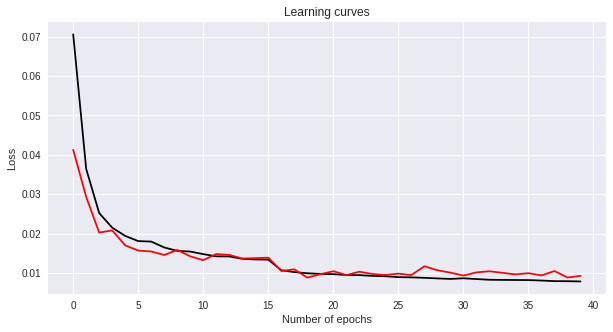

In [45]:
# Plotting learning curves
plt.figure(figsize=(10,5))
plt.plot(history_order.history['loss'], 'k', label='Training loss')
plt.plot(history_order.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Learning curves')
plt.show()

When looking at the loss curves, we can see that the validation loss tightly follows the training loss indicating that we have managed to avoid overfitting. However, as we see with the next normalization method, the training loss can go much lower than in this case.

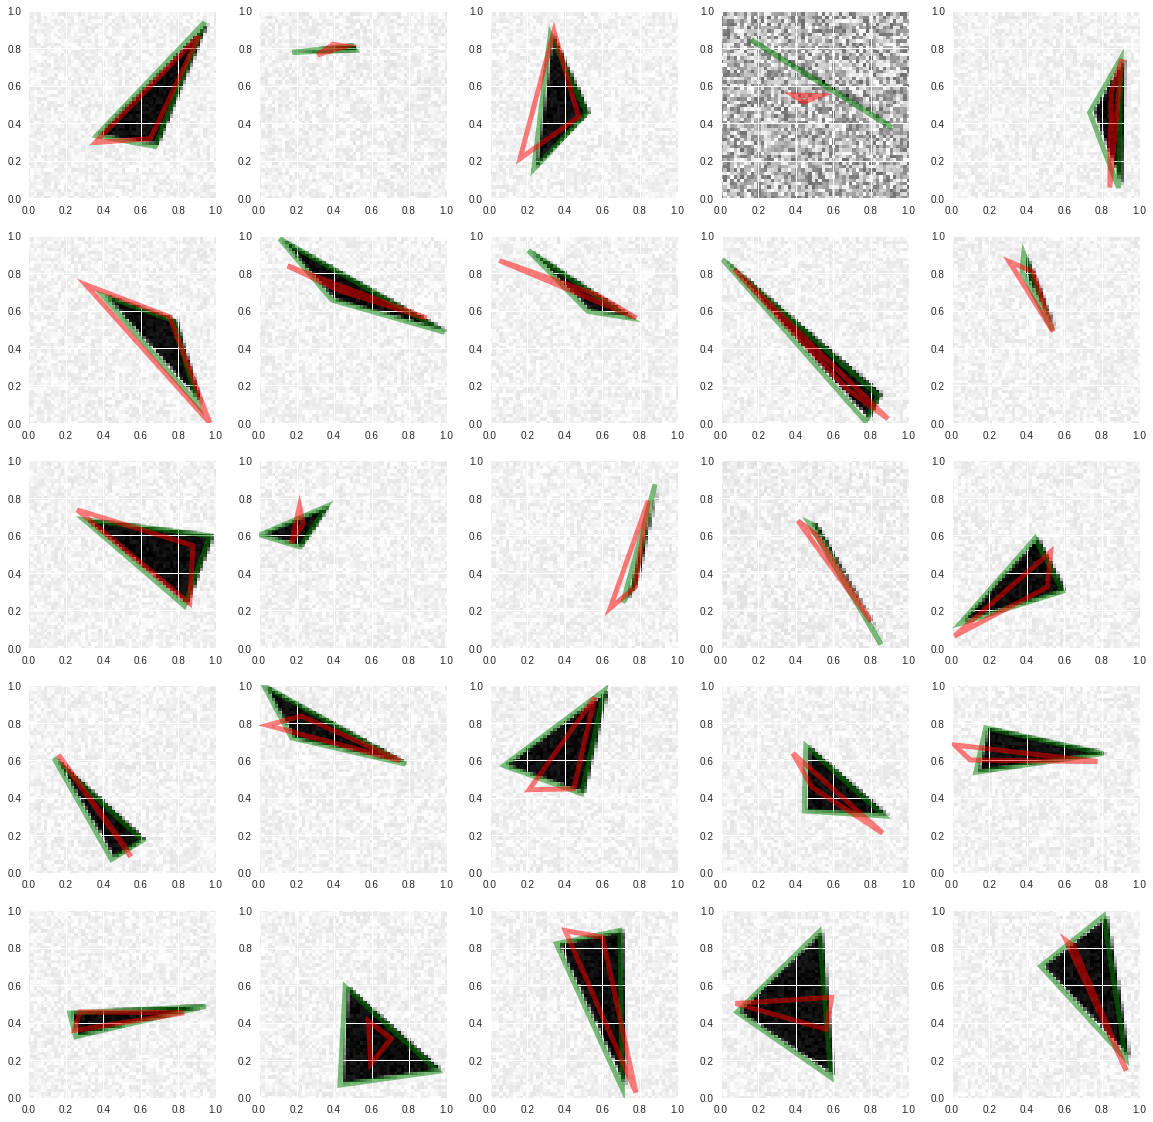

In [46]:
# Prediction results
plot_predictions(regressor1, X_val_order_cnn[:30], Y_val_order_cnn[:30])

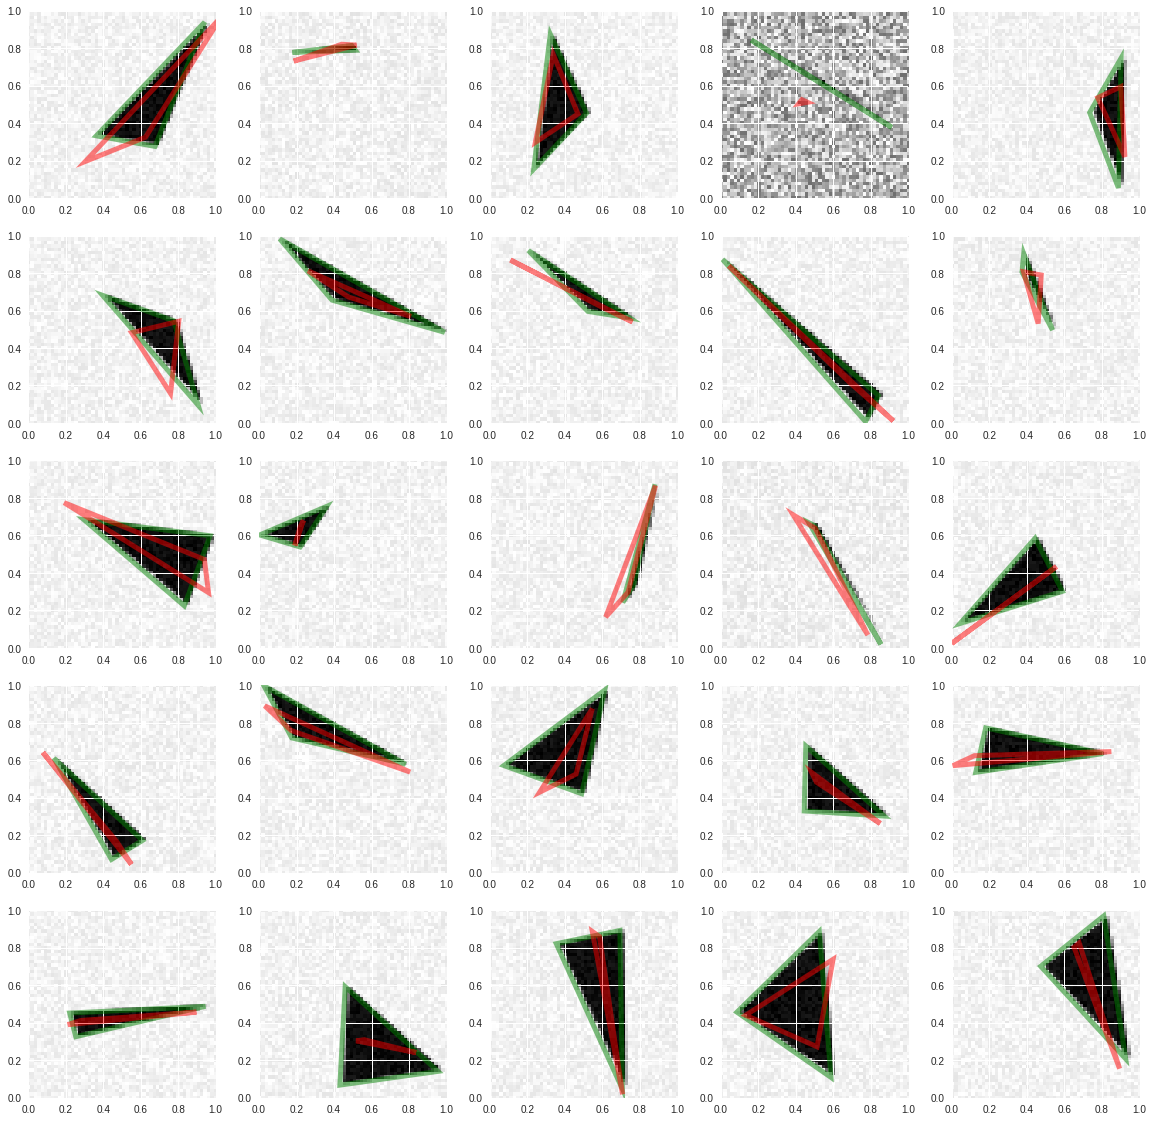

In [49]:
# Restoring the best parameters
from tensorflow.keras.models import Model

latest = tf.train.latest_checkpoint(checkpoint_dir)
best_model = my_regressor(lr=0.003, n_classes=n_classes, drop_rate=0.03, decay=0)
best_model.load_weights(latest)

plot_predictions(best_model, X_val_order_cnn[:30], Y_val_order_cnn[:30])

### c. Ordering clockwise

** Training**

I used **callbacks** to perform **learning rate decay** when the validation loss is no longer decreasing
and **checkpoints **so that we keep the best weights e.g. the best performing model on the
validation set. 

Used a lot of data and some dropout to avoid overfitting the data.
Indeed as the model used has over 95k parameters, bias was not an issue a priori.


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [51]:
X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn = get_datasets(ordering='clockwise', 
                                                                                                                          with_center=False)
n_classes = Y_train_order_cnn.shape[1]
regressor1 = my_regressor(lr=0.003, n_classes=n_classes, drop_rate=0.02, decay=0)

Number of classes :  6


In [52]:
n_epochs = 50
n_data = 18000

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=7, min_lr=0.0001)


# Checkpoint to be able to restore the best performing parameters
checkpoint_path = "training6/cp_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True)

history_order = regressor1.fit(X_train_order_cnn[:n_data], Y_train_order_cnn[:n_data], 
                              epochs=n_epochs,
                              batch_size=16, 
                              validation_data=[X_val_order_cnn, Y_val_order_cnn],
                              verbose=1, 
                              callbacks=[reduce_lr, checkpoint])


Train on 18000 samples, validate on 100 samples
Epoch 1/50
17984/18000 [============================>.] - ETA: 0s - loss: 0.0237WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f9f98615198>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.
18000/18000 [==============================] - 15s 828us/step - loss: 0.0237 - val_loss: 0.0153
Epoch 2/50
17920/18000 [============================>.] - ETA: 0s - loss: 0.0117WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f9f98615198>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimiz

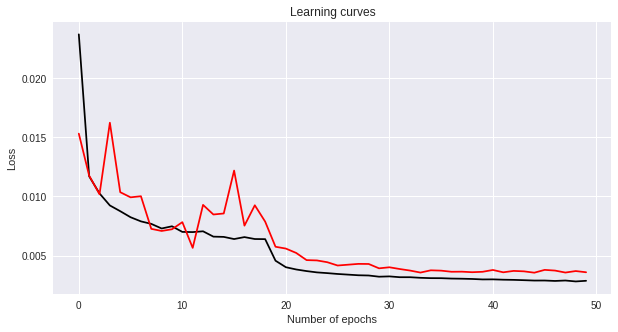

In [53]:
# Learning curves
plt.figure(figsize=(10,5))
plt.plot(history_order.history['loss'], 'k', label='Training loss')
plt.plot(history_order.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Learning curves')
plt.show()

On the figure above we can see that we eventually have a plateau indicating that the model
converged.
The training loss is quite low which indicates that there is no bias. 
The validation loss quite tightly follows the training loss  : the obtained loss values are way lower than for the other methods.


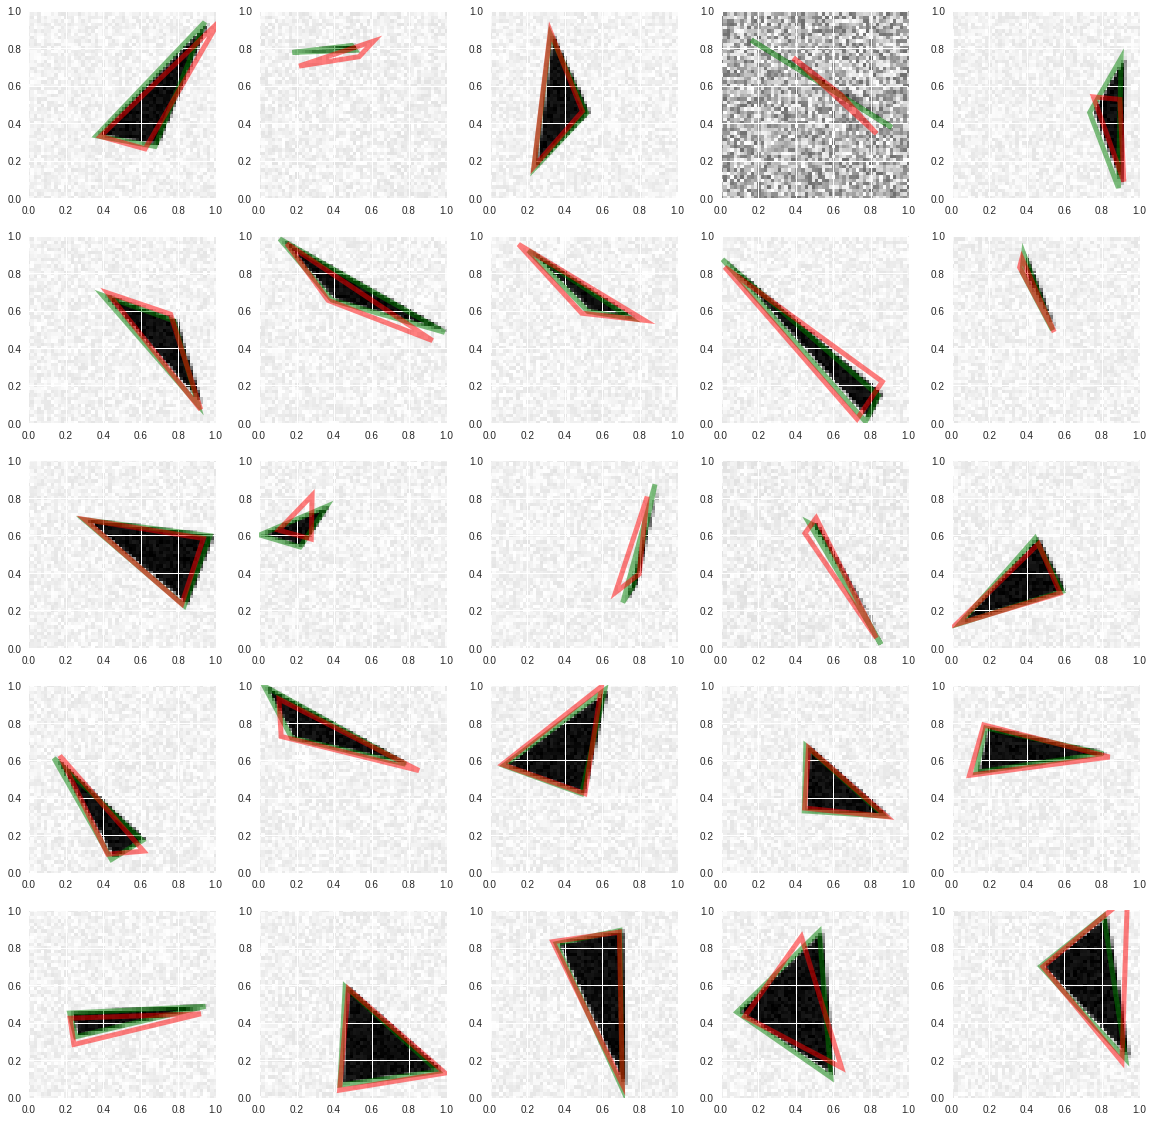

In [57]:
# Prediction results
plot_predictions(regressor1, X_val_order_cnn[:30], Y_val_order_cnn[:30])

**Restoring the best performing parameters**

Here we restore the best performing model, e.g. the model that gave the lowest validation loss

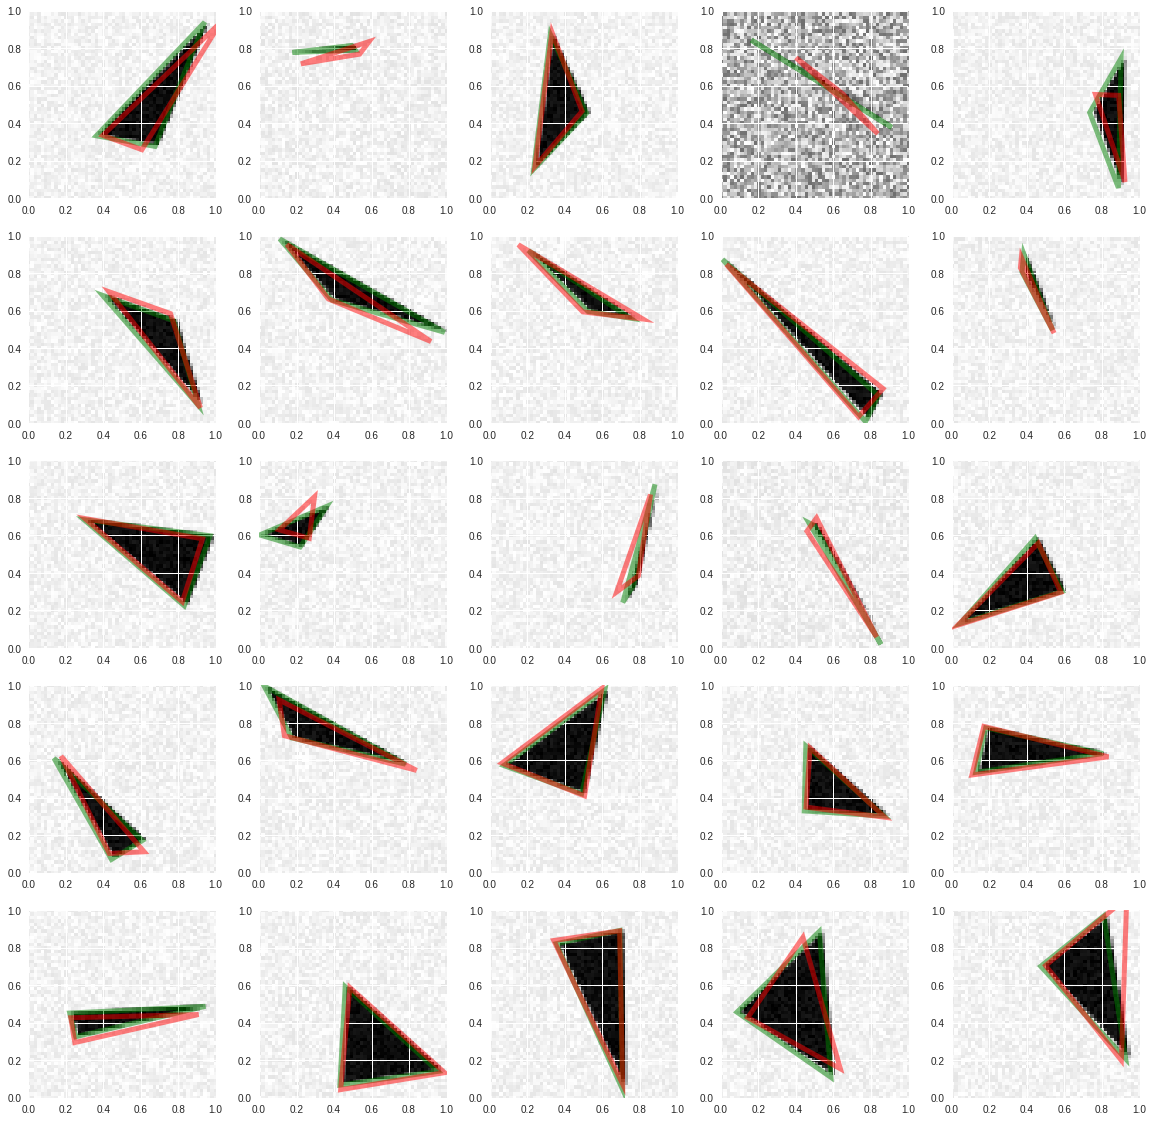

In [55]:
from tensorflow.keras.models import Model

latest = tf.train.latest_checkpoint(checkpoint_dir)
best_model = my_regressor(lr=0.003, n_classes=n_classes, drop_rate=0.006, decay=0)
best_model.load_weights(latest)

plot_predictions(best_model, X_val_order_cnn[:30], Y_val_order_cnn[:30])

### d. Ordering with polar coordinates

Loss values are too high, predictions are all over the place --> no good, which is not that surprising as the same discontinuities as in the naive order method occur.

In [60]:
X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn = get_datasets(ordering='polar', with_center=False)
n_classes = Y_train_order_cnn.shape[1]
regressor_polar = my_regressor(lr=0.005, n_classes=n_classes, drop_rate=0.01, decay=0)

Number of classes :  6


In [61]:
n_epochs = 40
n_data = 15000
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0005, patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5, verbose=0, mode='auto', baseline=None)
history_order = regressor_polar.fit(X_train_order_cnn[:n_data], Y_train_order_cnn[:n_data], 
                              epochs=n_epochs,
                              batch_size=16, 
                              validation_data=[X_val_order_cnn, Y_val_order_cnn],
                              verbose=1, 
                              callbacks=[reduce_lr])


Train on 15000 samples, validate on 100 samples
Epoch 1/40
15000/15000 [==============================] - 13s 847us/step - loss: 265.1652 - val_loss: 171.3260
Epoch 2/40
15000/15000 [==============================] - 11s 734us/step - loss: 177.7283 - val_loss: 162.4324
Epoch 3/40
15000/15000 [==============================] - 11s 740us/step - loss: 70.3438 - val_loss: 25.9482
Epoch 4/40
15000/15000 [==============================] - 11s 735us/step - loss: 19.9143 - val_loss: 17.6104
Epoch 5/40
15000/15000 [==============================] - 11s 737us/step - loss: 17.7000 - val_loss: 11.8633
Epoch 6/40
15000/15000 [==============================] - 11s 738us/step - loss: 14.1406 - val_loss: 10.5786
Epoch 7/40
15000/15000 [==============================] - 11s 734us/step - loss: 11.0007 - val_loss: 8.8099
Epoch 8/40
15000/15000 [==============================] - 11s 731us/step - loss: 9.7298 - val_loss: 11.0287
Epoch 9/40
15000/15000 [==============================] - 11s 740us/step - los

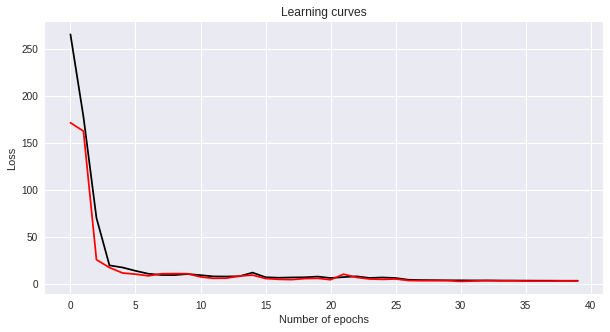

In [62]:
# Learning curves
plt.figure(figsize=(10,5))
plt.plot(history_order.history['loss'], 'k', label='Training loss')
plt.plot(history_order.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Learning curves')
plt.show()

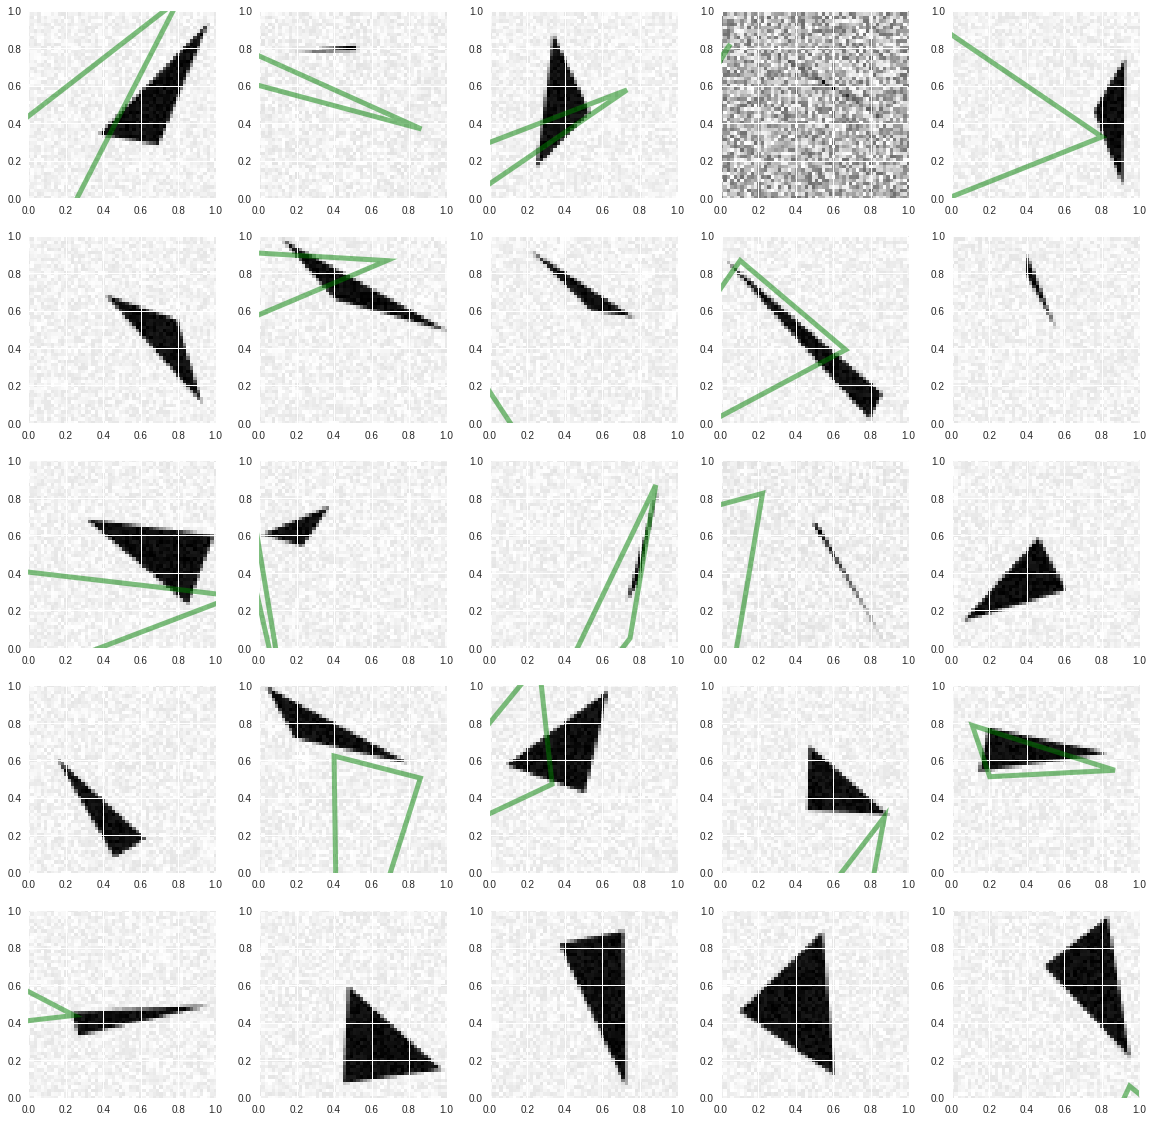

In [63]:
# Visualizing predictions
plot_predictions(regressor_polar, X_val_order_cnn[:30], Y_val_order_cnn[:30], ordering='polar')

### e. Ordering according to distance to the barycentre

In [67]:
X_train_order_cnn, Y_train_order_cnn, X_val_order_cnn, Y_val_order_cnn, X_test_order_cnn, Y_test_order_cnn = get_datasets(ordering='barycentre', with_center=False)
n_classes = Y_train_order_cnn.shape[1]
regressor_bary = my_regressor(lr=0.005, n_classes=n_classes, drop_rate=0.01, decay=0)

Number of classes :  6


In [68]:
n_epochs = 40
n_data = 15000
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.0005, patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=5, verbose=0, mode='auto', baseline=None)
history_order = regressor_bary.fit(X_train_order_cnn[:n_data], Y_train_order_cnn[:n_data], 
                              epochs=n_epochs,
                              batch_size=16, 
                              validation_data=[X_val_order_cnn, Y_val_order_cnn],
                              verbose=1, 
                              callbacks=[reduce_lr])

Train on 15000 samples, validate on 100 samples
Epoch 1/40
15000/15000 [==============================] - 13s 872us/step - loss: 0.0655 - val_loss: 0.0541
Epoch 2/40
15000/15000 [==============================] - 11s 732us/step - loss: 0.0431 - val_loss: 0.0324
Epoch 3/40
15000/15000 [==============================] - 11s 730us/step - loss: 0.0317 - val_loss: 0.0312
Epoch 4/40
15000/15000 [==============================] - 11s 747us/step - loss: 0.0298 - val_loss: 0.0259
Epoch 5/40
15000/15000 [==============================] - 11s 732us/step - loss: 0.0283 - val_loss: 0.0255
Epoch 6/40
15000/15000 [==============================] - 11s 733us/step - loss: 0.0270 - val_loss: 0.0269
Epoch 7/40
15000/15000 [==============================] - 11s 734us/step - loss: 0.0261 - val_loss: 0.0255
Epoch 8/40
15000/15000 [==============================] - 11s 729us/step - loss: 0.0256 - val_loss: 0.0230
Epoch 9/40
15000/15000 [==============================] - 11s 732us/step - loss: 0.0258 - val_lo

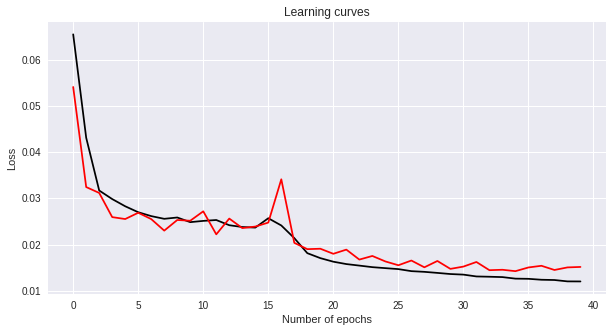

In [69]:
# Learning curves
plt.figure(figsize=(10,5))
plt.plot(history_order.history['loss'], 'k', label='Training loss')
plt.plot(history_order.history['val_loss'], 'r', label='Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Learning curves')
plt.show()

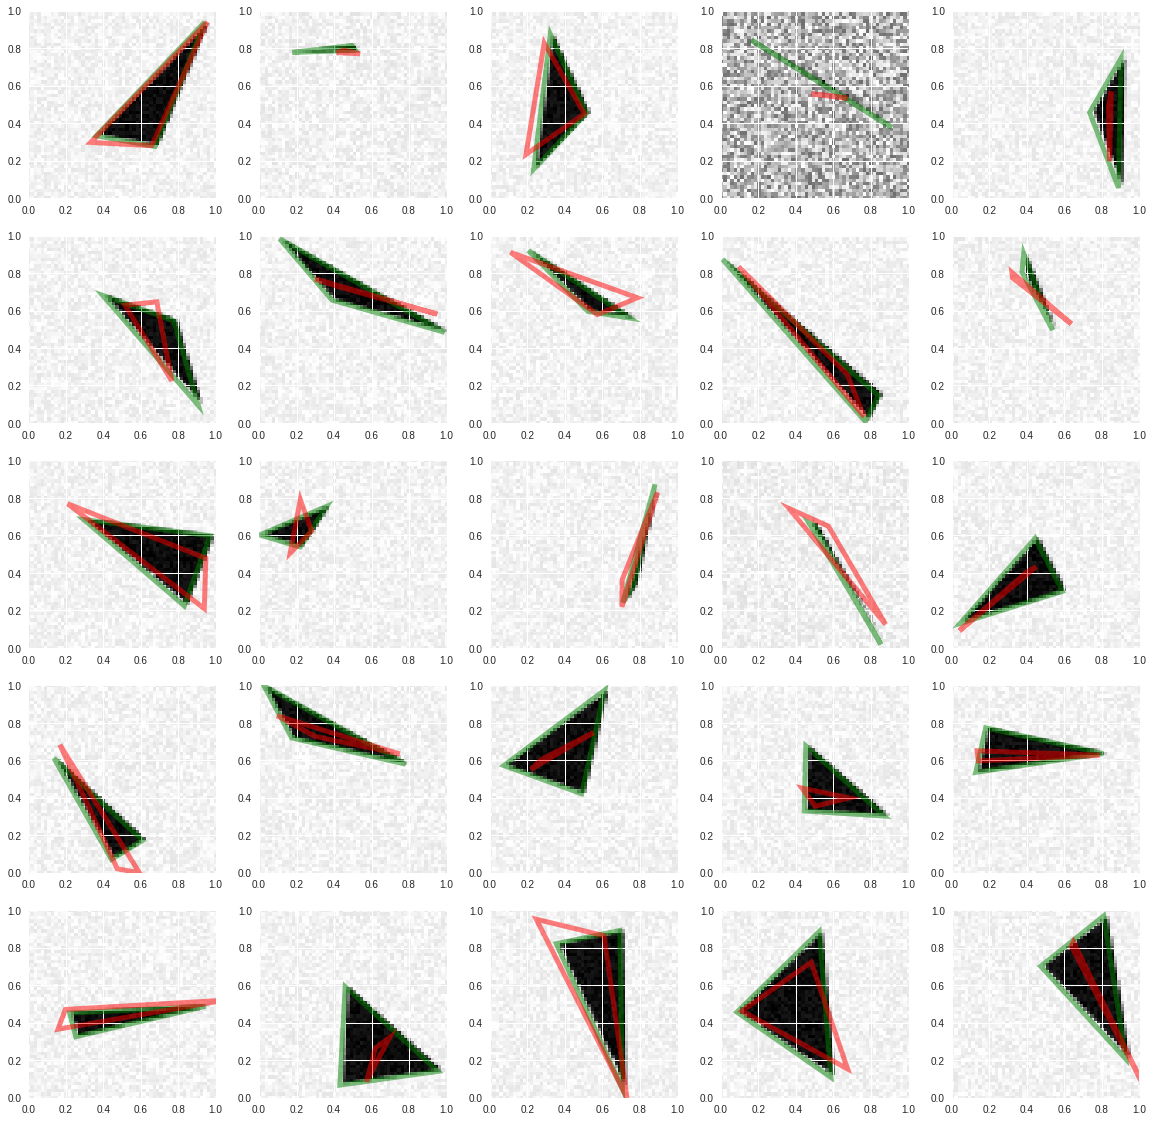

In [71]:
# Visualizing predictions
plot_predictions(regressor_bary, X_val_order_cnn[:30], Y_val_order_cnn[:30])